The transfer function for the causal LTI system with a realization $(A, B, C, D)$ is given by
\begin{equation*}
    H(s) = C(sI_{n} - A)^{-1}B.
\end{equation*}
Notice that $H(s) = Cv(s)$, where $v(s)$ is the solution of a parametrized linear coercive model
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$. In other words, we replace the matrix computation of $(sI_{n} - A)^{-1}B$ with a parametrized model (1). However, if one wants to apply this to the Iterative rational Krylov algorithm (IRKA), then the following matrix computations must be done to construct the projection matrices $V$ and $W$:
\begin{equation*}
    (-\mu_{i}I_{n} - A)^{-1}B\hat{b}_{i}, \quad \text{and} \quad (-\mu_{i}I_{n} - A)^{-*}C^{T}\hat{c}_{i} \quad \text{for } i = 1,\ldots,r,
\end{equation*}
where $-\mu_{i}, \hat{c}_{i}, \hat{b}_{i}$ are some initial interpolation data and $0 < r \leq n$ is the desired order of approximating ROM. So, we have decided to solve two parametrized linear coercive models to construct projection matrices $V$ and $W$:
\begin{equation}
    a_{1}(v_{1}, w; s) = l_{1}(w) \quad \text{and} \quad a_{2}(v_{2}, w; s) = l_{2}(w),
\end{equation}
where $a_{1}(v_{1}, w; s) = w^{*}(sI_{n} - A)v_{1}$ and $l_{1}(w) = w^{*}B$, and $a_{2}(v_{2}, w; s) = w^{*}(sI_{n} - A)^{*}v_{2}$ and $l_{2}(w) = w^{*}C^{T}$, and solutions to these parametrized linear coercive models are
\begin{equation*}
    v_{1}(s) = (sI_{n} - A)^{-1}B \quad \text{and} \quad v_{2}(s) = (sI_{n} - A)^{-*}C^{T}.
\end{equation*}
Therefore, knowing $v_{1}(\mu_{i})$ and $v_{2}(\mu_{i})$ for $i = 1, \ldots, r$ will suffice for constructing the projection matrices $V$ and $W$. Also, note that these two FOMs are parameter-separable, i.e.,
\begin{equation*}
    a_{1}(v_{1},w;s) = w^{*}(sI_{n} - A)v_{1} = sw^{*}I_{n}v_{1} - w^{*}Av_{1}  \quad  a_{2}(v_{2},w;s) = w^{*}(sI_{n} - A)^{*}v_{2} = \overline{s}w^{*}I_{n}v_{2} - w^{*}A^{*}v_{2}.
\end{equation*}

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from numpy.linalg import inv
from pymor.basic import *
from pymor.models.basic import StationaryModel
from pymor.operators.constructions import LincombOperator
from pymor.operators.numpy import NumpyMatrixOperator
from pymor.parameters.functionals import ProjectionParameterFunctional
from pymor.vectorarrays.numpy import NumpyVectorSpace

### Constructing a stationary model
Let us construct a stationary model of the following parametrized linear coercive model using `pyMOR`:
\begin{equation}
    a(v, w; s) = l(w),
\end{equation}
where $a(v, w; s) = w^{*}(sI_{n} - A)v$ and $l(w) = w^{*}B$.

In [2]:
def MatrixModel(A, B, dim: int):

    '''
    This function create a stationary model of the following linear coercive model derived for the given two matrices A and B:
    
        a(v, w; s) =w^{*}(sI_{n} - A)v and l(w) = w^{*}B.
    '''
    
    # Create Numpy vector space
    vector_space = NumpyVectorSpace(dim)

    # Define NumpyMatrixOperators
    I_op = NumpyMatrixOperator(np.eye(dim))

    if isinstance(A, np.ndarray) and isinstance(B, np.ndarray):
        A_op = NumpyMatrixOperator(A)
        B_op = NumpyMatrixOperator(B.reshape(-1, 1))
    else:
        A_op = A
        B_op = B       

    # Define parameter functional for 's'
    s_param = ProjectionParameterFunctional('s', 1)

    # Define bilinear form a(v, w; s) = w^* (sI - A)v
    a_op = LincombOperator([I_op, A_op], [s_param, -1])

    # Define linear functional l(w) = w^*B
    l_op = B_op

    # Define the StationaryModel
    model = StationaryModel(operator = a_op, rhs = l_op)

    return model

### Examples
Notice that to make this process more convenient, we provide two options for input matrices. If one has the matrices as `NumPy` arrays, they can import them directly without changing their type to work with `pyMOR`. Additionally, if one wants to input matrices from existing `pyMOR` models, this can also be done directly. To demonstrate this, we provide two examples: one with random matrices that we construct ourselves, and the other with matrices imported from the `penzl_example` in `pymor.models.examples`.


In [3]:
# Stationary model constructed using random numpy arrays

# Randomly generated arrays
np.random.seed(127)
matrixA = np.random.rand(20, 20)
matrixB = B = np.random.rand(20)

model_numpy = MatrixModel(A = matrixA, B = matrixB, dim = 20)
model_numpy

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<20x20 dense>), NumpyMatrixOperator(<20x20 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<20x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(20)),
    products={},
    output_d_mu_use_adjoint=True)

In [4]:
# Set parameter for evaluation
parameter = {'s': 1.4}  # s = 1.4

# Solve the model
solution = model_numpy.solve(parameter).to_numpy()

# Exact matrix computation
exact = (inv(parameter['s']*np.eye(20) - matrixA)@matrixB).reshape(1, 20)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The exact value of the matrix computation (1.4I - A)^{-1}B is 
 [[ 1.10896524  1.96032033  0.02339715  0.52739001 -0.35238441 -1.85189312
  -0.11570617 -0.4575037   0.55493919 -0.96350068  1.01490125  0.05632634
   0.23435721 -0.72291187  0.47195613 -1.1582535  -0.48791287  0.20426283
  -0.56944887 -0.30429143]].
The L-infinity error is 2.4424906541753444e-15.


In [5]:
# Stationary model constructed using matrices obtained from penzl example
from pymor.models.examples import penzl_example

penzl = penzl_example()

model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)
model_penzl

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<1006x1006 dense>), NumpyMatrixOperator(<1006x1006 sparse, 1012 nnz>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<1006x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(1006)),
    products={},
    output_d_mu_use_adjoint=True)

In [6]:
from pymor.algorithms.to_matrix import to_matrix

# Set parameter for evaluation
parameter = {'s': -1 + 2*1j}  # s = - 1 + 2i

# Solve the model
solution = model_penzl.solve(parameter).to_numpy()

# Exact matrix computation
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

exact = (inv(parameter['s']*np.eye(penzl.order) - matrixA)@matrixB).reshape(1, penzl.order)

# A comparison between the model's result and the exact matrix computation
print(f'The solution to the linear coercive model is \n {solution}.')
print(f'The exact value of the matrix computation ({parameter["s"]}I - A)^{{-1}}B is \n {exact}.')
print(f'The L-infinity error is {np.max(abs(exact - solution))}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The solution to the linear coercive model is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The exact value of the matrix computation ((-1+2j)I - A)^{-1}B is 
 [[ 0.10004002+2.00080032e-03j -0.10004002+2.00080032e-03j
   0.050005  +5.00050005e-04j ...  0.001003  -2.01204612e-06j
   0.001002  -2.00801600e-06j  0.001001  -2.00399798e-06j]].
The L-infinity error is 2.7755575615628914e-17.


## Reduced Basis Methods

As an example, we will use `penzl_example` from `pymor.models.examples` to construct a reduced basis using the reduced basis methods available in `pyMOR`.

In [134]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

### POD-Galerkin Method

In [183]:
# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a training set
training_set = parameter_space.sample_randomly(50)

# Compute FOM solutions for the parameters in the training set
solution_snapshots = model_penzl.solution_space.empty()
for s in training_set:
    solution_snapshots.append(model_penzl.solve(s))

# Snapshot matrix S
snapshot_matrix = solution_snapshots.to_numpy().T
print(f'An {snapshot_matrix.shape[0]} by {snapshot_matrix.shape[1]} snapshot matrix is \n {snapshot_matrix}')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

An 1006 by 50 snapshot matrix is 
 [[ 0.10719385  0.10350336  0.10490881 ...  0.10489405  0.10594788
   0.10551194]
 [-0.09157961 -0.09623192 -0.09455359 ... -0.09457178 -0.09324158
  -0.09379982]
 [ 0.05188379  0.05089327  0.05126335 ...  0.05125942  0.05154232
   0.05142468]
 ...
 [ 0.00099517  0.00099936  0.00099781 ...  0.00099783  0.00099663
   0.00099713]
 [ 0.00099418  0.00099836  0.00099682 ...  0.00099684  0.00099564
   0.00099614]
 [ 0.00099319  0.00099737  0.00099583 ...  0.00099584  0.00099465
   0.00099515]]


In [184]:
#pod_basis, pod_singular_values = pod(solution_snapshots, rtol = 0, atol = 0)
#pod_singular_values

In [185]:
# Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True) # using 'pod_basis, pod_singular_values = pod(solution_snapshots)' gives wrong result (pod_basis._len != 10 (5 != 10)); that's why we don't use it here. 

# Activate below to automatically select the number of modes based on the energy criterion
## The number of modes m should be chosen based on the energy criterion, which ensures that a sufficient portion of the system's total energy (or variance) is captured by the first m modes.
#cumulative_energy = np.cumsum(D**2) / np.sum(D**2)

##Select the number of modes m to capture at least 95% of the energy
#threshold = 0.95  # 95% of the total energy
#m = np.argmax(cumulative_energy >= threshold) + 1

m = 14 # this is also a reduction order

if m > min(snapshot_matrix.shape):
    raise ValueError("m cannot exceed the rank of the snapshot matrix.")

# The reduced basis (POD basis)
pod_basis_numpy = U[:,:m]
#print(f'The reduced basis (containing the first {m} left singular vectors (POD modes) of the snapshot matrix as its columns) is \n {pod_basis_numpy}')
print(D)

[3.96294871e+00 9.68198465e-01 1.65798997e-01 2.24812536e-02
 2.98601345e-03 3.56014155e-04 3.84215481e-05 3.20867082e-06
 2.84131746e-07 2.71426258e-08 1.98958930e-09 1.67370377e-10
 1.28993269e-11 8.64654357e-13 5.41785800e-14 2.91761738e-15
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 3.74712063e-16 3.74712063e-16 3.74712063e-16
 3.74712063e-16 5.70447134e-17]


In [168]:
from pymor.reductors.basic import StationaryRBReductor

# Convert NumPy array into VectorArray 
'''
The two lines below are the correct way to convert a NumPy reduced basis array into a VectorArray. However, the 'StationaryRBReductor' raises an error because 
'pod_basis in model_penzl.solution_space' is set to False. This happens because 'pod_basis.dim' is not equal to 'model_penzl.solution_space.dim'. This is 
expected since pod_basis.dim equals m (the number of modes, which can vary and is not fixed), whereas model_penzl.solution_space.dim is a fixed integer.
'''
#space = NumpyVectorSpace(m)
#pod_basis = space.make_array(pod_basis_numpy)

space = NumpyVectorSpace(model_penzl.order)
pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

# POD-Galerkin RB method
pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
pod_rom = pod_reductor.reduce()
pod_rom

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

StationaryModel(
    LincombOperator(
        (NumpyMatrixOperator(<14x14 dense>), NumpyMatrixOperator(<14x14 dense>)),
        (ProjectionParameterFunctional('s', index=0), -1)),
    NumpyMatrixOperator(<14x1 dense>),
    output_functional=ZeroOperator(NumpyVectorSpace(0), NumpyVectorSpace(14)),
    products={},
    output_d_mu_use_adjoint=True,
    name='StationaryModel_reduced')

True

In [169]:
import time

# Start timing
start_time_reduce = time.time()

# Define a parameter space
parameter_space = model_penzl.parameters.space(0.01, 10.)

# Define a validation set
r = 15
validation_set = parameter_space.sample_randomly(r)

# Solution array containing r many reduced samples
reduced_solution = pod_rom.solution_space.empty()
for s in validation_set:
    reduced_solution.append(pod_rom.solve(s))

# End timing
end_time_reduce = time.time()

# Compute and print the elapsed time
elapsed_time_reduce = end_time_reduce - start_time_reduce

# Reconstruct high-dimensional vector from reduced vector (necessary for error analysis)
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

print(f'The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is \n {reduced_solution_reconstruct}')

The reconstructed reduced solution matrix (with rows representing the reconstructed reduced solutions for different parameter values) is 
 [[ 0.10695353 -0.09190818  0.05181728 ...  0.00099546  0.00099447
   0.00099348]
 [ 0.10133294 -0.09863053  0.05033556 ...  0.00100165  0.00100065
   0.00099965]
 [ 0.10788679 -0.09060935  0.0520774  ...  0.00099433  0.00099334
   0.00099235]
 ...
 [ 0.10467865 -0.09483576  0.0512022  ...  0.00099807  0.00099708
   0.00099608]
 [ 0.10496671 -0.09448214  0.05127877 ...  0.00099775  0.00099675
   0.00099576]
 [ 0.10875187 -0.0893474   0.05232332 ...  0.00099325  0.00099226
   0.00099128]]


In [170]:
## Exact matrix computation

# Start timing
start_time_exact = time.time()

matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# End timing
end_time_exact = time.time()

# Compute and print the elapsed time
elapsed_time_exact = end_time_exact - start_time_exact

In [171]:
## Error analysis

# Start timing
start_time_full = time.time()

# FOM solution
full_solution = model_penzl.solution_space.empty()
for s in validation_set:
    full_solution.append(model_penzl.solve(s))
    
# End timing
end_time_full = time.time()

# Compute and print the elapsed time
elapsed_time_full = end_time_full - start_time_full

# Convert FOM solution into NumPy array
full_solution_numpy = full_solution.to_numpy()

# ROM solution
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()

print(f'The L-infinity norm of (Exact solution - FOM solution) is {np.linalg.norm(exact_solution - full_solution_numpy, np.inf)}.')
print(f'The L-infinity norm of (FOM solution - ROM solution) is {np.linalg.norm(full_solution_numpy - reduced_solution_reconstruct_numpy, np.inf)}.')
print(f'The L-infinity norm of (Exact solution - ROM solution) is {np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)}.')
print(f'The L-2 norm of (Exact solution - FOM solution) is {np.linalg.norm(exact_solution - full_solution_numpy, 2)}.')
print(f'The L-2 norm of (FOM solution - ROM solution) is {np.linalg.norm(full_solution_numpy - reduced_solution_reconstruct_numpy, 2)}.')
print(f'The L-2 norm of (Exact solution - ROM solution) is {np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)}.')

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

The L-infinity norm of (Exact solution - FOM solution) is 3.122502256758253e-17.
The L-infinity norm of (FOM solution - ROM solution) is 1.9453969685168104e-13.
The L-infinity norm of (Exact solution - ROM solution) is 1.9453969685168104e-13.
The L-2 norm of (Exact solution - FOM solution) is 3.518316691549412e-17.
The L-2 norm of (FOM solution - ROM solution) is 4.473390794310779e-14.
The L-2 norm of (Exact solution - ROM solution) is 4.473332395176986e-14.


In [172]:
# Computational time analysis (execution time analysis)
print(f'Total computation time of POD-Galerkin ROM: {elapsed_time_reduce:.10f} seconds.')
print(f'Total computation time of FOM: {elapsed_time_full:.10f} seconds.')
print(f'Total computation time of Exact: {elapsed_time_exact:.10f} seconds.')

Total computation time of POD-Galerkin ROM: 0.0100016594 seconds.
Total computation time of FOM: 0.9152729511 seconds.
Total computation time of Exact: 3.2772560120 seconds.


### Summary of POD-Galerkin Method

In [58]:
def MatrixReductor(A, B, dim: int, training_set, validation_set, reduced_order: int):

    # Construct Matrix induced StationaryModel
    model_penzl = MatrixModel(A, B, dim = dim)

    # Compute FOM solutions for the parameters in the training set
    solution_snapshots = model_penzl.solution_space.empty()
    for s in training_set:
        solution_snapshots.append(model_penzl.solve(s))

    # Snapshot matrix S
    snapshot_matrix = solution_snapshots.to_numpy().T

    # Finding the Singular Value Decomposition (SVD) of the snapshot matrix -> S = UΣV^T
    U, D, Vt = np.linalg.svd(snapshot_matrix, full_matrices = True)

    if reduced_order > min(snapshot_matrix.shape):
        raise ValueError("'reduced_order' cannot exceed the rank of the snapshot matrix.")

    # The reduced basis (POD basis)
    pod_basis_numpy = U[:,:reduced_order]

    # Convert NumPy array into VectorArray 
    space = NumpyVectorSpace(model_penzl.order)
    pod_basis = space.make_array(pod_basis_numpy.T) #This is actually transpose of POD-RB basis

    # POD-Galerkin RB method
    pod_reductor = StationaryRBReductor(model_penzl, RB = pod_basis) 
    pod_rom = pod_reductor.reduce()

    # Solution array containing r many reduced samples
    reduced_solution = pod_rom.solution_space.empty()
    for s in validation_set:
        reduced_solution.append(pod_rom.solve(s))

    return reduced_solution

#### Examples

In [125]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

A = penzl.A
B = penzl.B
dim = penzl.order 
parameter_space = model_penzl.parameters.space(0.01, 10.)
training_set = parameter_space.sample_randomly(10)
validation_set = parameter_space.sample_randomly(5)

reduced_solution = MatrixReductor(A, B, dim, training_set, validation_set, reduced_order = 10)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
reduced_solution_reconstruct_numpy

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

array([[ 0.1240651 , -0.09723263,  0.05925208, ...,  0.00111094,
         0.00110984,  0.00110874],
       [ 0.12603648, -0.11491314,  0.06173383, ...,  0.00120556,
         0.00120436,  0.00120316],
       [ 0.12405733, -0.09716843,  0.05924326, ...,  0.0011106 ,
         0.0011095 ,  0.0011084 ],
       [ 0.12999508, -0.12631163,  0.0644115 , ...,  0.00128057,
         0.00127928,  0.00127801],
       [ 0.12406654, -0.09724462,  0.05925372, ...,  0.001111  ,
         0.0011099 ,  0.0011088 ]])

In [126]:
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data
order_list = np.arange(1, 11)
linf_list = np.zeros(10)
l2_list = np.zeros(10)
for i in range(10):
    reduced_solution = MatrixReductor(A, B, dim, training_set, validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

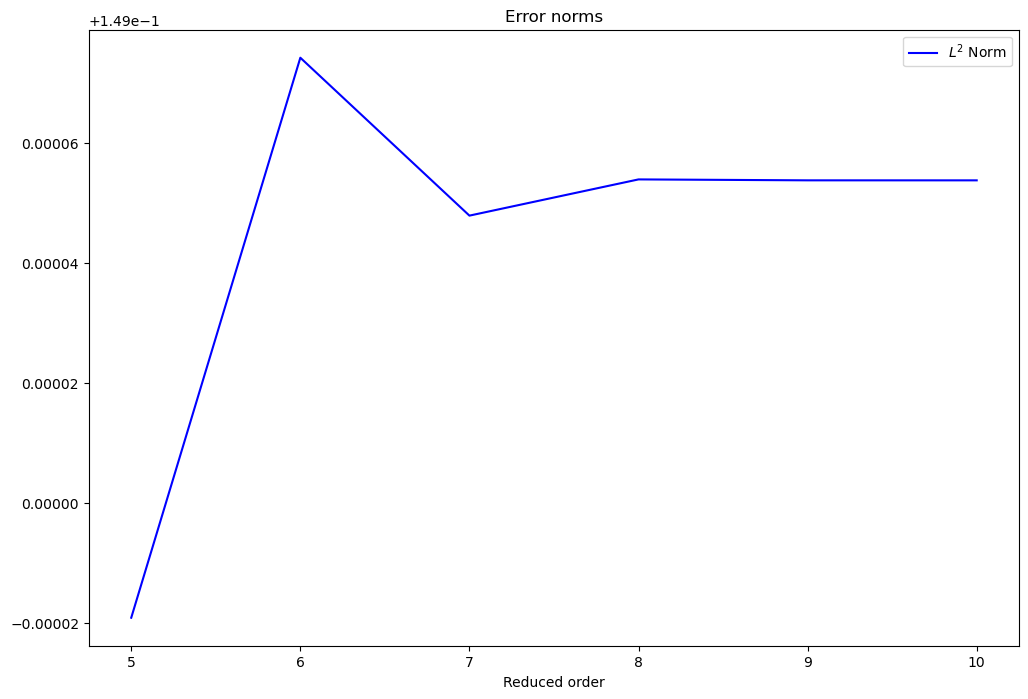

In [127]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
#ax.plot(order_list[4:], linf_list[4:], label = r"$L^\infty$ Norm", color='red', ms = 0.8)
ax.plot(order_list[4:], l2_list[4:], label = r"$L^2$ Norm", color='blue', ms = 0.9)
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

In [121]:
linf_list

array([5.37397224, 0.74200263, 0.81366214, 0.85134227, 0.85351708,
       0.85284334])

### Imaginary Training and Validation Set (A Vital Step for IRKA)
Here we will take imaginary training set to examine the result we obtain for Matrix Reduction.

In [105]:
from pymor.parameters.base import Mu

# Create an imaginary training set
card_training_set = 30
complex_parameters = 10*np.random.random_sample((card_training_set,)) + 10*1j*np.random.random_sample((card_training_set,))
imaginary_training_set = []
for i in range(card_training_set):
    imaginary_training_set.append(Mu({'s': np.array(complex_parameters[i])}))

# Create a validation set
card_validation_set = 10
complex_parameters_validation = 15*np.random.random_sample((card_training_set,)) + 15*1j*np.random.random_sample((card_training_set,))
imaginary_validation_set = []
for k in range(10):
    imaginary_validation_set.append(Mu({'s': np.array(complex_parameters_validation[k])}))
print(f'An imaginary training set is {imaginary_training_set}.')
print(f'An imaginary validation set is {imaginary_validation_set}.')

An imaginary training set is [Mu({'s': array([6.74237103+7.74724153j])}), Mu({'s': array([9.15255989+0.79497812j])}), Mu({'s': array([3.80554321+3.8831264j])}), Mu({'s': array([6.01969348+9.79164109j])}), Mu({'s': array([3.36587859+5.54887135j])}), Mu({'s': array([0.06058778+9.31553676j])}), Mu({'s': array([3.70550633+4.70374672j])}), Mu({'s': array([0.65164738+2.8738046j])}), Mu({'s': array([2.52213807+7.95506969j])}), Mu({'s': array([7.04630034+5.28555905j])}), Mu({'s': array([0.75704223+6.62010234j])}), Mu({'s': array([8.47281604+5.98377745j])}), Mu({'s': array([3.26719187+0.21004541j])}), Mu({'s': array([5.80761611+6.50199494j])}), Mu({'s': array([9.88339938+4.43618938j])}), Mu({'s': array([2.34559955+7.72651049j])}), Mu({'s': array([7.07998598+1.08729795j])}), Mu({'s': array([5.196788+1.61708533j])}), Mu({'s': array([6.69269526+4.89442035j])}), Mu({'s': array([1.10035021+1.54956832j])}), Mu({'s': array([1.11922441+9.19511486j])}), Mu({'s': array([0.38762307+0.31469226j])}), Mu({'s

In [130]:
from pymor.models.examples import penzl_example

penzl = penzl_example()
model_penzl = MatrixModel(penzl.A, penzl.B, dim = penzl.order)

A = penzl.A
B = penzl.B
dim = penzl.order 

# Reduced solution
reduced_solution = MatrixReductor(A, B, dim, imaginary_training_set, imaginary_validation_set, reduced_order = 20)

# Reconstruct high-dimensional vector from reduced vector
reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)

# Reconstructed high-dimensional NumPy array (necessary for error analysis)
reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
reduced_solution_reconstruct_numpy

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

array([[ 0.09446921-3.20906765e-03j, -0.08091677+5.49040636e-03j,
         0.04553573-1.64772664e-03j, ...,  0.00087304-3.87847760e-05j,
         0.00087217-3.87447908e-05j,  0.0008713 -3.87048880e-05j],
       [ 0.09632236-1.05086230e-02j, -0.08536396+8.40936049e-03j,
         0.04659161-5.01134687e-03j, ...,  0.00090097-9.44166223e-05j,
         0.00090007-9.43230435e-05j,  0.00089918-9.42296602e-05j],
       [ 0.09782919+1.03860985e-03j, -0.07805741-1.64077798e-03j,
         0.04690892+7.48458419e-04j, ...,  0.00088391+1.73311734e-05j,
         0.00088303+1.73135327e-05j,  0.00088216+1.72959279e-05j],
       ...,
       [ 0.08566245+1.02058111e-03j, -0.08147032-9.42322596e-03j,
         0.04227232+1.32207619e-03j, ...,  0.00083525+5.05148240e-05j,
         0.00083442+5.04600376e-05j,  0.00083358+5.04053691e-05j],
       [ 0.09712148+7.48806847e-04j, -0.07869406-1.98543571e-04j,
         0.04661996+5.09926929e-04j, ...,  0.00088175+9.33607017e-06j,
         0.00088088+9.32701067e-06j

In [131]:
matrixA = to_matrix(penzl.A).toarray()
matrixB = to_matrix(penzl.B)

# Create a NumPy array containing parameters
s_values = np.array([s['s'] for s in imaginary_validation_set]) 

# Identity matrix of appropriate size
identity = np.eye(penzl.order)

# Exact solution
exact_solution = np.vstack([(np.linalg.inv(s * identity - matrixA) @ matrixB).flatten() for s in s_values])

# Data
order_list = np.arange(1, 21)
linf_list = np.zeros(20)
l2_list = np.zeros(20)
for i in range(20):
    reduced_solution = MatrixReductor(A, B, dim, imaginary_training_set, imaginary_validation_set, reduced_order = i)
    reduced_solution_reconstruct = pod_reductor.reconstruct(reduced_solution)
    reduced_solution_reconstruct_numpy = reduced_solution_reconstruct.to_numpy()
    linf_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, np.inf)
    l2_list[i] = np.linalg.norm(exact_solution - reduced_solution_reconstruct_numpy, 2)

Accordion(children=(HTML(value='', layout=Layout(height='16em', width='100%')),), titles=('Log Output',))

KeyboardInterrupt: 

In [ ]:
# Error norm plot
fig, ax = plt.subplots(figsize=(12, 8), dpi=100)
ax.plot(order_list, linf_list, label = r"$L^\infty$ Norm", color='red', ms = 0.8)
ax.plot(order_list, l2_list, label = r"$L^2$ Norm", color='blue', ms = 0.9)
ax.set_title("Error norms")
ax.set_xlabel("Reduced order")
ax.legend()

# Show the plot
plt.show()

In [128]:
linf_list

array([7.56221326, 2.41599404, 1.60715875, 1.55522064, 1.50319945,
       1.51121979, 1.50991854, 1.51021236, 1.51017569, 1.51018162])